In [ ]:
# Intallation packages before use Jupyter

# !pip install pandas
# !pip install -U scikit-learn
# !pip install keras
# !pip install matplotlib
# !pip install kaleido
# !pip install plotly

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
# from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from math import sqrt
import matplotlib
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
# be able to save images on server
matplotlib.use('Agg')

# Not show warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# !pip install -U kaleido # w Google Colab wymagany Runtime restart po instalacji (Runtime -> Restart Runtime)
import kaleido #required
# kaleido.__version__ #0.2.1

print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


2024-06-18 12:39:17.326558: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.16.1
Num GPUs Available:  1


In [2]:
# Zip
# importing the "tarfile" module
import tarfile # type: ignore

# open file
file = tarfile.open('1_150x9.tar.gz')

# extracting a specific file
file.extractall(path='./1_150x9/')

file.close()

In [3]:
# Data generator
def data(time, features):
    # Timestep 
    # timestepsPerSample = 20
    timestepsPerSample = time

    # Timesteps in input data
    timestepsPerSampleWholeData = 150

    # Replace 'your_file.csv' with the actual file path
    file_features = './1_150x9/1_150x9f.csv'
    file_labels = './1_150x9/1_150x9l.csv'

    # Read the .csv file and create an array
    data_strings = np.genfromtxt(file_features, delimiter=';')
    labels_strings = np.genfromtxt(file_labels,delimiter=';')


    # Wycinanie wybranych kolumn
    #  0    1         2             3        4       5        6    7        8
    # RSI, VWAP, HeikenResult, closeHeiken, CMF, Stochastic, OBV, QQE, TrendFilter
    # data_s = data_strings[:,[0,2,3,4,5,6,7,8]]
    if features == 0:
        data_s = data_strings[:,[0,4,5,8]]
    elif features == 1:
        data_s = data_strings[:,[0,1,4,5,6,8]]
    elif features == 2:
        data_s = data_strings[:,:]
        
    num_features = data_s.shape[1]
    # print(data_strings[:3])
    # print(data_s[:3])

    
    # Convert from strings to float and int
    X = data_s.astype(float).reshape((-1,timestepsPerSampleWholeData,num_features))
    Y = labels_strings.astype(float).reshape((-1,3))
    # print(X.shape)
    # print(Y.shape)

    # Modification from imported to new size X[samples,timesteps]
    X_mod = X[1000:11000,timestepsPerSampleWholeData - timestepsPerSample:]
    Y_mod = Y[1000:11000]
    timestepsPerSampleWholeData = X_mod.shape[1]
    # print(X_mod.shape)
    # print(Y_mod.shape)
    # print(X_mod[:1])

    # Splitting
    x_train, x_test, Y_train, Y_test = train_test_split(X_mod,Y_mod, test_size=0.15, shuffle=False)
    y_train = Y_train[:, 0:2]
    y_test = Y_test[:, 0:2]
    # print(y_train[:2])
    # print(y_test[:2])

    # Summarize
    num_samples = x_train.shape[0]
    test_samples = x_test.shape[0]
    print(f"Train shape: {x_train.shape}")
    print(f"Timesteps: {timestepsPerSampleWholeData}")
    print(f"Num Samples: {num_samples}")
    print(f"Test Samples: {test_samples}")
    print(f"Num features: {num_features}")
    return x_train, x_test, y_train, y_test, Y_test

In [4]:
# fit lstm model
from tabnanny import verbose


def fit_lstmModel(x_train, y_train, x_test, y_test, batch_size, nb_epoch, neurons, denseType, dropout, model):
    if model == 0:
        model = Sequential()

        # Assuming `data` is your input matrix with shape (samples, time_steps, features)
        model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],x_train.shape[2])))
        model.add(Dropout(0.2))

        model.add(LSTM(units=50, return_sequences=False))
        model.add(Dropout(0.2))

        model.add(Dense(units=25))
        model.add(Dropout(0.2))

        # Output layer for price prediction
        model.add(Dense(y_train.shape[1], activation='sigmoid'))

    elif model == 1:
        model = Sequential()

        # Assuming `data` is your input matrix with shape (samples, time_steps, features)
        model.add(LSTM(units=150, return_sequences=True, input_shape=(x_train.shape[1],x_train.shape[2])))
        model.add(Dropout(0.2))

        model.add(LSTM(units=150, return_sequences=False))
        model.add(Dropout(0.2))

        model.add(Dense(units=75))
        model.add(Dropout(0.2))

        # Output layer for price prediction
        model.add(Dense(y_train.shape[1], activation='sigmoid'))

    elif model == 2:
        model = Sequential()

        # Assuming `data` is your input matrix with shape (samples, time_steps, features)
        model.add(LSTM(units=300, return_sequences=True, input_shape=(x_train.shape[1],x_train.shape[2])))
        model.add(Dropout(0.2))

        model.add(LSTM(units=300, return_sequences=False))
        model.add(Dropout(0.2))

        model.add(Dense(units=150))
        model.add(Dropout(0.2))

        # Output layer for price prediction
        model.add(Dense(y_train.shape[1], activation='sigmoid'))

    
    num_samples = x_train.shape[0]
    STEPS_PER_EPOCH = num_samples/batch_size

    # lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    0.001,
    decay_steps=STEPS_PER_EPOCH*100,
    decay_rate=0.9,
    staircase=False)

    # Callback EarlyStopping
    callback = EarlyStopping(monitor='val_loss',
                                             start_from_epoch=10,
                                             restore_best_weights=True,
                                             verbose=0,
                                             patience=5)

    def get_optimizer():
         # return tf.keras.optimizers.Adam(learning_rate=0.001)
        return tf.keras.optimizers.Adam(learning_rate= lr_schedule) # type: ignore

    optimizer = get_optimizer()

    # defining loss function, optimizer, metrics and then compiling model
    model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
    model.summary()

    # fit model
    history = model.fit(x_train, y_train, epochs=nb_epoch, batch_size=batch_size, 
                        shuffle=False, validation_data=(x_test, y_test), callbacks=callback, verbose=2) # type: ignore
    return model, history

In [5]:
# Profit
def funcProfit(predict, Y_test):
    predict_classes = np.where(predict > 0.5, 1,0)
    concat = np.hstack((predict_classes, Y_test[:,2:]))
    df = pd.DataFrame(concat, columns=['Sell', 'Buy', 'Price'])

    # Absolute difference prices
    sum = 0
    for i in range(0, len(df)):
        if (i-1) > 0:
            diff = abs((df.at[i,'Price'] - df.at[i-1,'Price']))
            if diff < 0.5:
                if df.at[i,'Sell'] == 1:
                    sum += (df.at[i,'Price'] - df.at[i-1,'Price'])*(-1)
                elif df.at[i,'Buy'] == 1:
                    sum += (df.at[i,'Price'] - df.at[i-1,'Price'])
                if df.at[i,'Sell'] != df.at[i-1,'Sell']:
                    sum -= 0.03
    return sum

In [6]:
# Experiment
def experiment(repeats, epochs, neurons, time, denseType, dropout, model, features):
    # Data gen
    x_train, x_test, y_train, y_test, Y_test = data(time, features)

    # Evaluate declaration
    accuracy = list()
    profit = list()
    metrics = list()

    # Repeats
    for r in range(repeats):
        print(f"Repeat {r} running...")
        # Batch size
        batch_size = 64
        # model
        model, history = fit_lstmModel(x_train, y_train, x_test, y_test, batch_size, epochs, neurons, denseType, dropout, model)

        # forecast the entire training dataset to build up state for forecasting
        predict = model.predict(x_test, batch_size=batch_size)
        test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0) # type: ignore

        metric = pd.DataFrame(history.history)
        metric['epoch'] = history.epoch

        metrics.append(metric)
        accuracy.append(test_acc*100)
        profit.append(funcProfit(predict, Y_test))
    
    return accuracy, profit, metrics

In [7]:
# Output
def plotsOut(d, metrics):
    fig = make_subplots(rows=1, cols=2, subplot_titles=('Accuracy', 'Loss'))

    # Layout - set size
    fig.update_layout(
        autosize=True,
        width=1000
    )

    for idx, m in enumerate(metrics):
        fig.add_trace(go.Scatter(x=m['epoch'], y=m['accuracy'], name=f'accuracy{str(idx)}', line_color='#0000ff', showlegend=False), row=1, col=1)
        fig.add_trace(go.Scatter(x=m['epoch'], y=m['loss'], name=f'loss{str(idx)}', line_color='#0000ff', showlegend=False), row=1, col=2)
        fig.add_trace(go.Scatter(x=m['epoch'], y=m['val_accuracy'], name=f'val_accuracy{str(idx)}', line_color='#EF8260', showlegend=False), row=1, col=1)
        fig.add_trace(go.Scatter(x=m['epoch'], y=m['val_loss'], name=f'val_loss{str(idx)}', line_color='#EF8260', showlegend=False), row=1, col=2)

    fig.update_xaxes(title_text='epochs')
    fig.update_yaxes(title_text='')
    # fig.update_layout(width=1000, title='Accuracy and Loss')
    fig.write_image(file=f"compare_models_{str(d)}.jpg", engine="kaleido")

In [8]:
# Run
from numpy import dtype

repeats = 4
results_acc = DataFrame(dtype='float')
results_profit = DataFrame(dtype='float')
metrics = list()

# vary training epochs
features = [0, 1, 2]
model = 0
dropout = 0.2
denseType = 0
neuronsLstm = 150
timeStep = 150
epochs = 100
for ft in features:
 print(f"{ft} Features test start...")
 results_acc[str(ft)], results_profit[str(ft)], metrics = experiment(repeats, epochs, neuronsLstm, timeStep, denseType, dropout, model, ft)
 plotsOut(ft, metrics)

# summarize results
print(results_acc.describe())
print(results_profit.describe())

0 Features test start...
Train shape: (8500, 150, 4)
Timesteps: 150
Num Samples: 8500
Test Samples: 1500
Num features: 4
Repeat 0 running...


2024-06-18 12:39:59.689780: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1117 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:09:00.0, compute capability: 8.6
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 150, 50)        │        11,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 150, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            52 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,527 (127.06 KB)

 Trainable params: 32,527 (127.06 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


2024-06-18 12:40:03.238637: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906


133/133 - 8s - 63ms/step - accuracy: 0.5932 - loss: 0.6711 - val_accuracy: 0.6620 - val_loss: 0.6378
Epoch 2/100
133/133 - 3s - 26ms/step - accuracy: 0.6366 - loss: 0.6447 - val_accuracy: 0.6707 - val_loss: 0.6156
Epoch 3/100
133/133 - 4s - 26ms/step - accuracy: 0.6512 - loss: 0.6340 - val_accuracy: 0.6820 - val_loss: 0.6056
Epoch 4/100
133/133 - 3s - 26ms/step - accuracy: 0.6561 - loss: 0.6280 - val_accuracy: 0.6813 - val_loss: 0.5992
Epoch 5/100
133/133 - 4s - 27ms/step - accuracy: 0.6587 - loss: 0.6234 - val_accuracy: 0.6907 - val_loss: 0.5914
Epoch 6/100
133/133 - 3s - 26ms/step - accuracy: 0.6700 - loss: 0.6164 - val_accuracy: 0.6980 - val_loss: 0.5828
Epoch 7/100
133/133 - 3s - 26ms/step - accuracy: 0.6772 - loss: 0.6086 - val_accuracy: 0.7040 - val_loss: 0.5717
Epoch 8/100
133/133 - 3s - 26ms/step - accuracy: 0.6881 - loss: 0.5990 - val_accuracy: 0.7187 - val_loss: 0.5629
Epoch 9/100
133/133 - 3s - 26ms/step - accuracy: 0.6885 - loss: 0.5965 - val_accuracy: 0.7280 - val_loss: 0.

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 150, 50)        │        11,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 150, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            52 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,527 (127.06 KB)

 Trainable params: 32,527 (127.06 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
133/133 - 6s - 46ms/step - accuracy: 0.7121 - loss: 0.5663 - val_accuracy: 0.7293 - val_loss: 0.5429
Epoch 2/100
133/133 - 3s - 26ms/step - accuracy: 0.7109 - loss: 0.5725 - val_accuracy: 0.7300 - val_loss: 0.5429
Epoch 3/100
133/133 - 3s - 26ms/step - accuracy: 0.7105 - loss: 0.5646 - val_accuracy: 0.7240 - val_loss: 0.5510
Epoch 4/100
133/133 - 3s - 26ms/step - accuracy: 0.7099 - loss: 0.5685 - val_accuracy: 0.7393 - val_loss: 0.5426
Epoch 5/100
133/133 - 3s - 26ms/step - accuracy: 0.7178 - loss: 0.5652 - val_accuracy: 0.7340 - val_loss: 0.5430
Epoch 6/100
133/133 - 3s - 26ms/step - accuracy: 0.7128 - loss: 0.5653 - val_accuracy: 0.7327 - val_loss: 0.5385
Epoch 7/100
133/133 - 3s - 26ms/step - accuracy: 0.7145 - loss: 0.5655 - val_accuracy: 0.7327 - val_loss: 0.5433
Epoch 8/100
133/133 - 3s - 26ms/step - accuracy: 0.7166 - loss: 0.5619 - val_accuracy: 0.7240 - val_loss: 0.5532
Epoch 9/100
133/133 - 4s - 26ms/step - accuracy: 0.7169 - loss: 0.5573 - val_accuracy: 0.7180 - 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 150, 50)        │        11,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 150, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            52 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,527 (127.06 KB)

 Trainable params: 32,527 (127.06 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
133/133 - 6s - 46ms/step - accuracy: 0.7255 - loss: 0.5477 - val_accuracy: 0.7127 - val_loss: 0.5548
Epoch 2/100
133/133 - 3s - 26ms/step - accuracy: 0.7301 - loss: 0.5444 - val_accuracy: 0.7127 - val_loss: 0.5560
Epoch 3/100
133/133 - 3s - 26ms/step - accuracy: 0.7324 - loss: 0.5371 - val_accuracy: 0.7020 - val_loss: 0.5639
Epoch 4/100
133/133 - 3s - 26ms/step - accuracy: 0.7425 - loss: 0.5300 - val_accuracy: 0.6927 - val_loss: 0.5738
Epoch 5/100
133/133 - 4s - 26ms/step - accuracy: 0.7314 - loss: 0.5392 - val_accuracy: 0.7033 - val_loss: 0.5579
Epoch 6/100
133/133 - 3s - 26ms/step - accuracy: 0.7367 - loss: 0.5271 - val_accuracy: 0.6733 - val_loss: 0.6146
Epoch 7/100
133/133 - 3s - 26ms/step - accuracy: 0.7318 - loss: 0.5360 - val_accuracy: 0.7147 - val_loss: 0.5555
Epoch 8/100
133/133 - 3s - 26ms/step - accuracy: 0.7364 - loss: 0.5369 - val_accuracy: 0.6947 - val_loss: 0.5872
Epoch 9/100
133/133 - 4s - 26ms/step - accuracy: 0.7326 - loss: 0.5343 - val_accuracy: 0.7127 - 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 150, 50)        │        11,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 150, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            52 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,527 (127.06 KB)

 Trainable params: 32,527 (127.06 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
133/133 - 6s - 45ms/step - accuracy: 0.7091 - loss: 0.5634 - val_accuracy: 0.7260 - val_loss: 0.5419
Epoch 2/100
133/133 - 3s - 26ms/step - accuracy: 0.7321 - loss: 0.5373 - val_accuracy: 0.7173 - val_loss: 0.5504
Epoch 3/100
133/133 - 3s - 26ms/step - accuracy: 0.7493 - loss: 0.5132 - val_accuracy: 0.6820 - val_loss: 0.5780
Epoch 4/100
133/133 - 3s - 26ms/step - accuracy: 0.7562 - loss: 0.5012 - val_accuracy: 0.6907 - val_loss: 0.6134
Epoch 5/100
133/133 - 3s - 26ms/step - accuracy: 0.7473 - loss: 0.5147 - val_accuracy: 0.6887 - val_loss: 0.5707
Epoch 6/100
133/133 - 3s - 26ms/step - accuracy: 0.7434 - loss: 0.5285 - val_accuracy: 0.7047 - val_loss: 0.5568
Epoch 7/100
133/133 - 3s - 26ms/step - accuracy: 0.7544 - loss: 0.5093 - val_accuracy: 0.7067 - val_loss: 0.5776
Epoch 8/100
133/133 - 3s - 26ms/step - accuracy: 0.7553 - loss: 0.5083 - val_accuracy: 0.7200 - val_loss: 0.5514
Epoch 9/100
133/133 - 4s - 26ms/step - accuracy: 0.7569 - loss: 0.5053 - val_accuracy: 0.6827 - 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:205: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 150, 50)        │        11,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 150, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            52 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,927 (128.62 KB)

 Trainable params: 32,927 (128.62 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
133/133 - 6s - 48ms/step - accuracy: 0.5998 - loss: 0.6657 - val_accuracy: 0.6740 - val_loss: 0.6309
Epoch 2/100
133/133 - 3s - 26ms/step - accuracy: 0.6408 - loss: 0.6405 - val_accuracy: 0.6767 - val_loss: 0.6117
Epoch 3/100
133/133 - 3s - 26ms/step - accuracy: 0.6524 - loss: 0.6328 - val_accuracy: 0.6800 - val_loss: 0.6030
Epoch 4/100
133/133 - 3s - 26ms/step - accuracy: 0.6555 - loss: 0.6275 - val_accuracy: 0.6880 - val_loss: 0.5941
Epoch 5/100
133/133 - 3s - 26ms/step - accuracy: 0.6607 - loss: 0.6206 - val_accuracy: 0.6940 - val_loss: 0.5860
Epoch 6/100
133/133 - 3s - 26ms/step - accuracy: 0.6698 - loss: 0.6145 - val_accuracy: 0.6987 - val_loss: 0.5776
Epoch 7/100
133/133 - 3s - 25ms/step - accuracy: 0.6781 - loss: 0.6069 - val_accuracy: 0.7047 - val_loss: 0.5680
Epoch 8/100
133/133 - 3s - 26ms/step - accuracy: 0.6821 - loss: 0.6007 - val_accuracy: 0.7207 - val_loss: 0.5605
Epoch 9/100
133/133 - 3s - 26ms/step - accuracy: 0.6900 - loss: 0.5955 - val_accuracy: 0.7240 - 

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 150, 50)        │        11,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 150, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            52 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,927 (128.62 KB)

 Trainable params: 32,927 (128.62 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
133/133 - 6s - 46ms/step - accuracy: 0.7008 - loss: 0.5832 - val_accuracy: 0.7273 - val_loss: 0.5443
Epoch 2/100
133/133 - 3s - 26ms/step - accuracy: 0.6998 - loss: 0.5803 - val_accuracy: 0.7273 - val_loss: 0.5425
Epoch 3/100
133/133 - 3s - 26ms/step - accuracy: 0.7029 - loss: 0.5811 - val_accuracy: 0.7267 - val_loss: 0.5426
Epoch 4/100
133/133 - 3s - 26ms/step - accuracy: 0.7004 - loss: 0.5803 - val_accuracy: 0.7200 - val_loss: 0.5439
Epoch 5/100
133/133 - 3s - 26ms/step - accuracy: 0.7042 - loss: 0.5759 - val_accuracy: 0.7000 - val_loss: 0.5604
Epoch 6/100
133/133 - 3s - 26ms/step - accuracy: 0.7014 - loss: 0.5798 - val_accuracy: 0.7040 - val_loss: 0.5506
Epoch 7/100
133/133 - 3s - 26ms/step - accuracy: 0.7032 - loss: 0.5747 - val_accuracy: 0.6860 - val_loss: 0.5732
Epoch 8/100
133/133 - 3s - 26ms/step - accuracy: 0.7031 - loss: 0.5771 - val_accuracy: 0.7060 - val_loss: 0.5564
Epoch 9/100
133/133 - 3s - 26ms/step - accuracy: 0.7049 - loss: 0.5742 - val_accuracy: 0.7060 - 

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 150, 50)        │        11,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 150, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            52 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,927 (128.62 KB)

 Trainable params: 32,927 (128.62 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
133/133 - 6s - 46ms/step - accuracy: 0.7160 - loss: 0.5605 - val_accuracy: 0.6893 - val_loss: 0.5758
Epoch 2/100
133/133 - 3s - 26ms/step - accuracy: 0.7174 - loss: 0.5601 - val_accuracy: 0.6887 - val_loss: 0.5843
Epoch 3/100
133/133 - 3s - 26ms/step - accuracy: 0.7235 - loss: 0.5516 - val_accuracy: 0.6833 - val_loss: 0.5936
Epoch 4/100
133/133 - 4s - 27ms/step - accuracy: 0.7241 - loss: 0.5556 - val_accuracy: 0.7020 - val_loss: 0.5668
Epoch 5/100
133/133 - 3s - 26ms/step - accuracy: 0.7020 - loss: 0.5796 - val_accuracy: 0.7053 - val_loss: 0.5666
Epoch 6/100
133/133 - 3s - 26ms/step - accuracy: 0.7151 - loss: 0.5617 - val_accuracy: 0.7087 - val_loss: 0.5575
Epoch 7/100
133/133 - 3s - 26ms/step - accuracy: 0.7219 - loss: 0.5527 - val_accuracy: 0.6720 - val_loss: 0.6245
Epoch 8/100
133/133 - 3s - 26ms/step - accuracy: 0.7242 - loss: 0.5451 - val_accuracy: 0.6853 - val_loss: 0.6024
Epoch 9/100
133/133 - 3s - 26ms/step - accuracy: 0.7324 - loss: 0.5374 - val_accuracy: 0.6567 - 

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 150, 50)        │        11,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 150, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            52 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,927 (128.62 KB)

 Trainable params: 32,927 (128.62 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
133/133 - 6s - 46ms/step - accuracy: 0.7591 - loss: 0.5092 - val_accuracy: 0.6293 - val_loss: 0.7739
Epoch 2/100
133/133 - 3s - 26ms/step - accuracy: 0.7481 - loss: 0.5188 - val_accuracy: 0.6627 - val_loss: 0.6847
Epoch 3/100
133/133 - 3s - 26ms/step - accuracy: 0.7524 - loss: 0.5145 - val_accuracy: 0.6487 - val_loss: 0.7782
Epoch 4/100
133/133 - 3s - 26ms/step - accuracy: 0.7480 - loss: 0.5167 - val_accuracy: 0.6380 - val_loss: 0.7325
Epoch 5/100
133/133 - 3s - 26ms/step - accuracy: 0.7454 - loss: 0.5221 - val_accuracy: 0.6420 - val_loss: 0.6626
Epoch 6/100
133/133 - 3s - 26ms/step - accuracy: 0.7598 - loss: 0.4932 - val_accuracy: 0.6227 - val_loss: 0.7624
Epoch 7/100
133/133 - 3s - 26ms/step - accuracy: 0.7682 - loss: 0.4844 - val_accuracy: 0.5993 - val_loss: 0.8593
Epoch 8/100
133/133 - 3s - 25ms/step - accuracy: 0.7624 - loss: 0.4924 - val_accuracy: 0.5987 - val_loss: 0.8626
Epoch 9/100
133/133 - 3s - 26ms/step - accuracy: 0.7569 - loss: 0.4941 - val_accuracy: 0.5940 - 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:205: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 150, 50)        │        12,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 150, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │            52 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,527 (130.96 KB)

 Trainable params: 33,527 (130.96 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
133/133 - 6s - 46ms/step - accuracy: 0.5885 - loss: 0.6728 - val_accuracy: 0.6733 - val_loss: 0.6348
Epoch 2/100
133/133 - 3s - 26ms/step - accuracy: 0.6384 - loss: 0.6422 - val_accuracy: 0.6760 - val_loss: 0.6135
Epoch 3/100
133/133 - 3s - 26ms/step - accuracy: 0.6514 - loss: 0.6335 - val_accuracy: 0.6807 - val_loss: 0.6023
Epoch 4/100
133/133 - 3s - 26ms/step - accuracy: 0.6578 - loss: 0.6261 - val_accuracy: 0.6900 - val_loss: 0.5954
Epoch 5/100
133/133 - 3s - 26ms/step - accuracy: 0.6633 - loss: 0.6213 - val_accuracy: 0.7000 - val_loss: 0.5871
Epoch 6/100
133/133 - 3s - 26ms/step - accuracy: 0.6735 - loss: 0.6113 - val_accuracy: 0.7007 - val_loss: 0.5758
Epoch 7/100
133/133 - 3s - 26ms/step - accuracy: 0.6806 - loss: 0.6037 - val_accuracy: 0.7167 - val_loss: 0.5670
Epoch 8/100
133/133 - 3s - 26ms/step - accuracy: 0.6876 - loss: 0.5978 - val_accuracy: 0.7207 - val_loss: 0.5569
Epoch 9/100
133/133 - 3s - 26ms/step - accuracy: 0.6899 - loss: 0.5919 - val_accuracy: 0.7213 - 

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 150, 50)        │        12,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 150, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │            52 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,527 (130.96 KB)

 Trainable params: 33,527 (130.96 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
133/133 - 6s - 47ms/step - accuracy: 0.7044 - loss: 0.5772 - val_accuracy: 0.7273 - val_loss: 0.5415
Epoch 2/100
133/133 - 3s - 26ms/step - accuracy: 0.7042 - loss: 0.5749 - val_accuracy: 0.7180 - val_loss: 0.5500
Epoch 3/100
133/133 - 3s - 26ms/step - accuracy: 0.7025 - loss: 0.5749 - val_accuracy: 0.6873 - val_loss: 0.5906
Epoch 4/100
133/133 - 3s - 26ms/step - accuracy: 0.7027 - loss: 0.5806 - val_accuracy: 0.7300 - val_loss: 0.5493
Epoch 5/100
133/133 - 3s - 26ms/step - accuracy: 0.7074 - loss: 0.5720 - val_accuracy: 0.7187 - val_loss: 0.5622
Epoch 6/100
133/133 - 3s - 26ms/step - accuracy: 0.7140 - loss: 0.5698 - val_accuracy: 0.6860 - val_loss: 0.5990
Epoch 7/100
133/133 - 4s - 26ms/step - accuracy: 0.7134 - loss: 0.5674 - val_accuracy: 0.7073 - val_loss: 0.5739
Epoch 8/100
133/133 - 3s - 25ms/step - accuracy: 0.7149 - loss: 0.5635 - val_accuracy: 0.6787 - val_loss: 0.6230
Epoch 9/100
133/133 - 3s - 26ms/step - accuracy: 0.7162 - loss: 0.5639 - val_accuracy: 0.6700 - 

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 150, 50)        │        12,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 150, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │            52 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,527 (130.96 KB)

 Trainable params: 33,527 (130.96 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
133/133 - 6s - 47ms/step - accuracy: 0.7152 - loss: 0.5671 - val_accuracy: 0.7140 - val_loss: 0.5777
Epoch 2/100
133/133 - 3s - 26ms/step - accuracy: 0.7224 - loss: 0.5522 - val_accuracy: 0.6807 - val_loss: 0.5976
Epoch 3/100
133/133 - 4s - 27ms/step - accuracy: 0.7299 - loss: 0.5434 - val_accuracy: 0.6700 - val_loss: 0.6081
Epoch 4/100
133/133 - 3s - 26ms/step - accuracy: 0.7313 - loss: 0.5392 - val_accuracy: 0.6780 - val_loss: 0.6166
Epoch 5/100
133/133 - 3s - 26ms/step - accuracy: 0.7285 - loss: 0.5448 - val_accuracy: 0.6667 - val_loss: 0.6190
Epoch 6/100
133/133 - 3s - 26ms/step - accuracy: 0.7332 - loss: 0.5411 - val_accuracy: 0.6880 - val_loss: 0.5938
Epoch 7/100
133/133 - 3s - 25ms/step - accuracy: 0.7398 - loss: 0.5261 - val_accuracy: 0.6413 - val_loss: 0.6682
Epoch 8/100
133/133 - 3s - 26ms/step - accuracy: 0.7395 - loss: 0.5289 - val_accuracy: 0.6647 - val_loss: 0.6418
Epoch 9/100
133/133 - 3s - 26ms/step - accuracy: 0.7404 - loss: 0.5307 - val_accuracy: 0.5960 - 

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 150, 50)        │        12,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 150, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │            52 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,527 (130.96 KB)

 Trainable params: 33,527 (130.96 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
133/133 - 7s - 50ms/step - accuracy: 0.7462 - loss: 0.5178 - val_accuracy: 0.6287 - val_loss: 0.7022
Epoch 2/100
133/133 - 3s - 26ms/step - accuracy: 0.7526 - loss: 0.4998 - val_accuracy: 0.6427 - val_loss: 0.7039
Epoch 3/100
133/133 - 3s - 26ms/step - accuracy: 0.7536 - loss: 0.5149 - val_accuracy: 0.5947 - val_loss: 0.8044
Epoch 4/100
133/133 - 3s - 26ms/step - accuracy: 0.7521 - loss: 0.5091 - val_accuracy: 0.6260 - val_loss: 0.7522
Epoch 5/100
133/133 - 4s - 26ms/step - accuracy: 0.7656 - loss: 0.4842 - val_accuracy: 0.6140 - val_loss: 0.8529
Epoch 6/100
133/133 - 3s - 26ms/step - accuracy: 0.7542 - loss: 0.5070 - val_accuracy: 0.6053 - val_loss: 0.7720
Epoch 7/100
133/133 - 4s - 27ms/step - accuracy: 0.7592 - loss: 0.4915 - val_accuracy: 0.6140 - val_loss: 0.8196
Epoch 8/100
133/133 - 4s - 27ms/step - accuracy: 0.7648 - loss: 0.4858 - val_accuracy: 0.6100 - val_loss: 0.8186
Epoch 9/100
133/133 - 3s - 26ms/step - accuracy: 0.7608 - loss: 0.5001 - val_accuracy: 0.6033 - 

In [9]:
# summarize results
print(results_acc.describe())
print(results_profit.describe())

               0          1          2
count   4.000000   4.000000   4.000000
mean   72.283334  68.500000  67.566667
std     0.604612   4.597099   3.658170
min    71.533334  63.200003  64.600003
25%    71.933332  65.400000  64.800002
50%    72.366667  69.033334  66.633335
75%    72.716668  72.133334  69.400001
max    72.866666  72.733331  72.399998
              0          1         2
count  4.000000   4.000000  4.000000
mean  -3.615000  -7.845000 -4.190000
std    0.891833   5.809816  1.707767
min   -4.390000 -14.740000 -5.680000
25%   -4.375000 -10.000000 -5.620000
50%   -3.685000  -8.050000 -4.375000
75%   -2.925000  -5.895000 -2.945000
max   -2.700000  -0.540000 -2.330000


               0          1          2
count   4.000000   4.000000   4.000000
mean   72.283334  68.500000  67.566667
std     0.604612   4.597099   3.658170
min    71.533334  63.200003  64.600003
25%    71.933332  65.400000  64.800002
50%    72.366667  69.033334  66.633335
75%    72.716668  72.133334  69.400001
max    72.866666  72.733331  72.399998


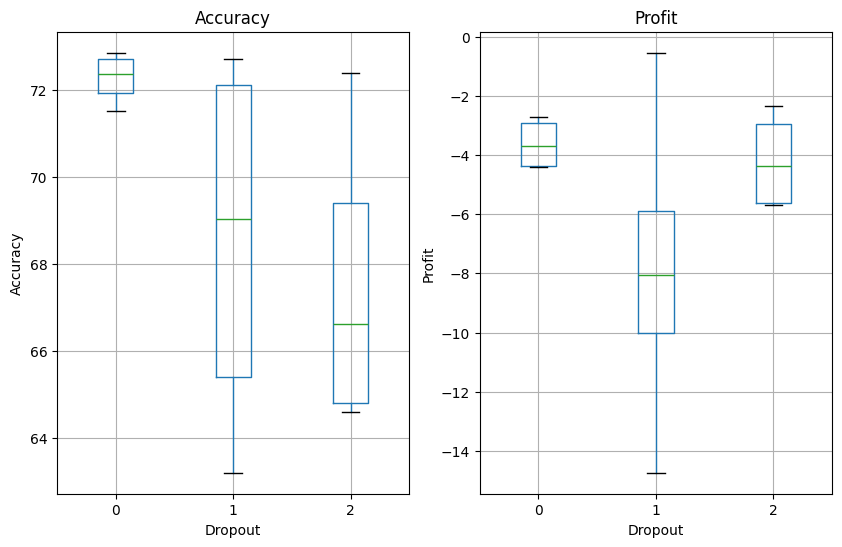

In [10]:
%matplotlib inline
print(results_acc.describe())

# 2 subplots in one row
fig, ax = plt.subplots(1, 2, figsize=(10, 6))

# Generate boxplots
results_acc.boxplot(ax=ax[0])
results_profit.boxplot(ax=ax[1])

# Set labels and titles
ax[0].set_title('Accuracy')
ax[0].set_xlabel('Dropout')
ax[0].set_ylabel('Accuracy')
ax[1].set_title('Profit')
ax[1].set_xlabel('Dropout')
ax[1].set_ylabel('Profit')

# Save to .png and show plot
plt.savefig(f'boxplot_features.png')
plt.show()